# Mixed Domain

## Data

The pickle file contains a dictionary:
* x_<train/valid>: data point with 2 feature columns
* y_<train/valid>: label
* d_<train/valid>: domain

The train-valid split is:
* Train: 2400 datapoints
* Valid: 300 datapoints

In [1]:
import pickle
data = pickle.load(open("./data/data_d0.75.pkl", "rb"))

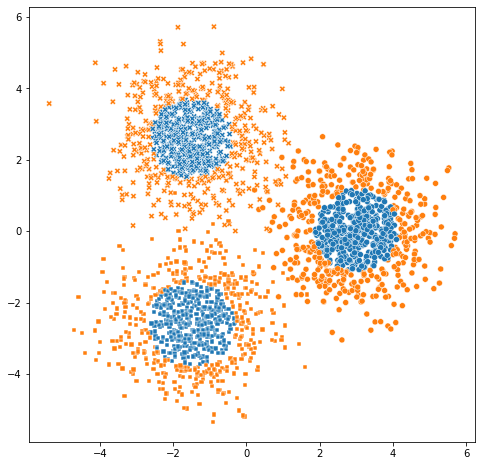

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(x=data['x_train'][:, 0], y=data['x_train'][:, 1],
                hue=data['y_train'], style=data['d_train'], legend=False
)

plt.show()

## Assignment Specifications

* Goal: To create a multi-domain FFNN of 2 hidden layers (20, 10) with ReLU as activation function.
* Report accuracy performance stats on validation set for random seeds [0, 10, 1234, 99, 2021].
* Train each model for 30,000 epochs using Adam optimizer (LR: 1e-3).


# Question 1: Implement a basic FNN (multi-domain model training)

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014385009126272053
INFO:util.loop:Validation loss: 0.1458161473274231
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.33333%


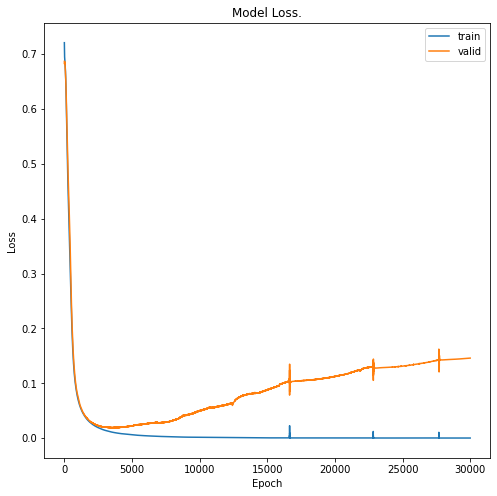

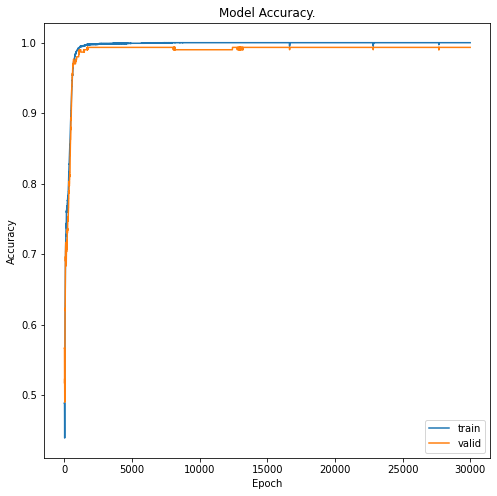

In [3]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
model = FFNN(random_state=0)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
model, _ = train(data, model, epochs, batch_size, optimizer, plot=True)



Random State 0:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014385009126272053
INFO:util.loop:Validation loss: 0.1458161473274231
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.33333%


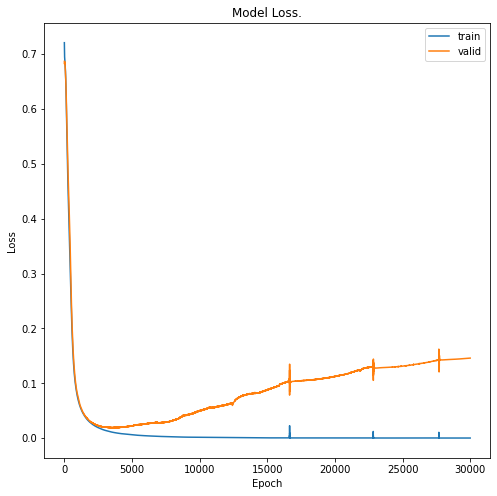

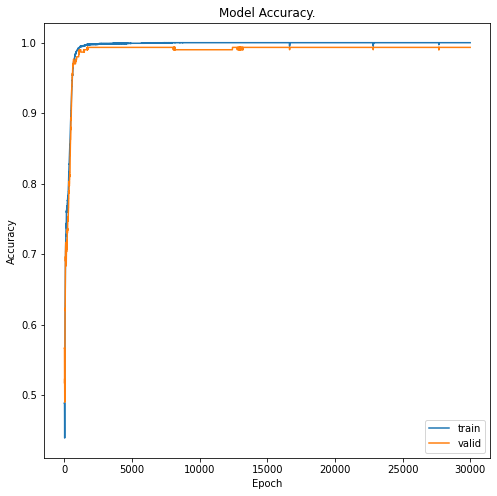



Random State 10:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00013502457295544446
INFO:util.loop:Validation loss: 0.04841307923197746
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.66667%


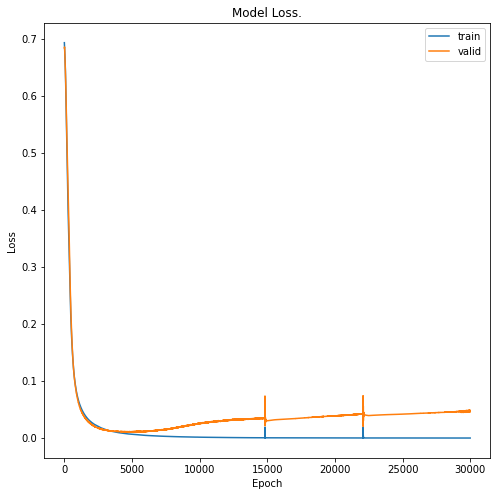

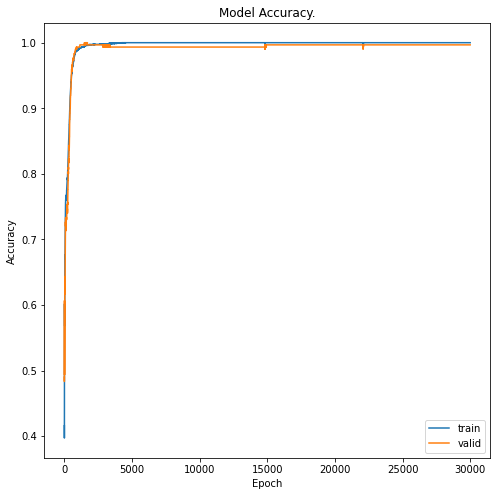



Random State 1234:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0002572239900473505
INFO:util.loop:Validation loss: 0.016970224678516388
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.33333%


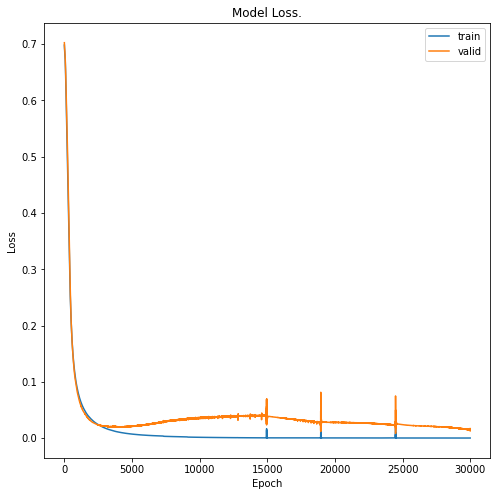

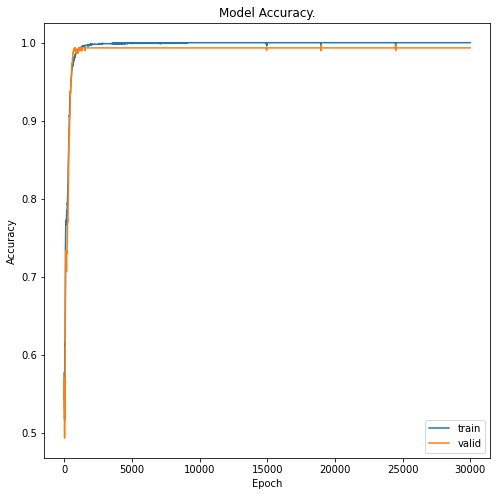



Random State 99:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0013424259377643466
INFO:util.loop:Validation loss: 0.02992812544107437
INFO:util.loop:Train acc: 99.91667%
INFO:util.loop:Validation acc: 99.66667%


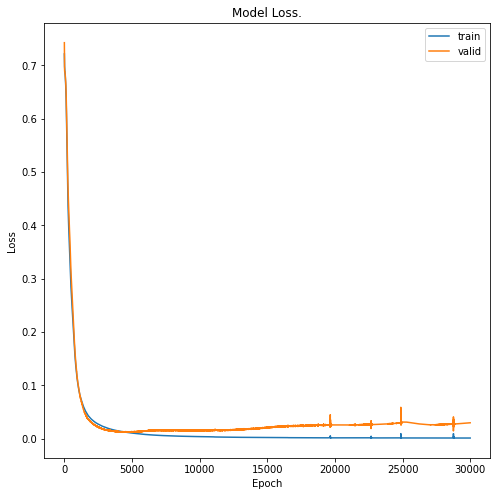

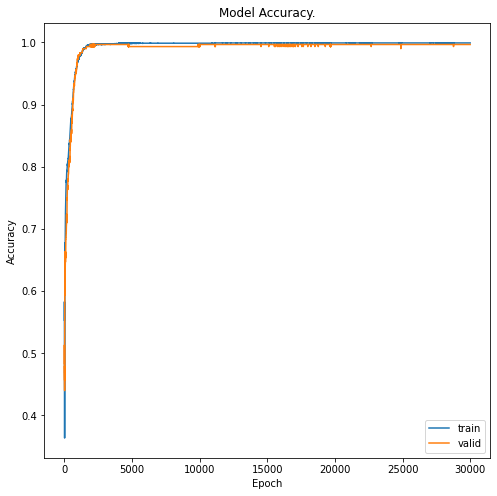



Random State 2021:


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00023230171063914895
INFO:util.loop:Validation loss: 0.041687168180942535
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.00000%


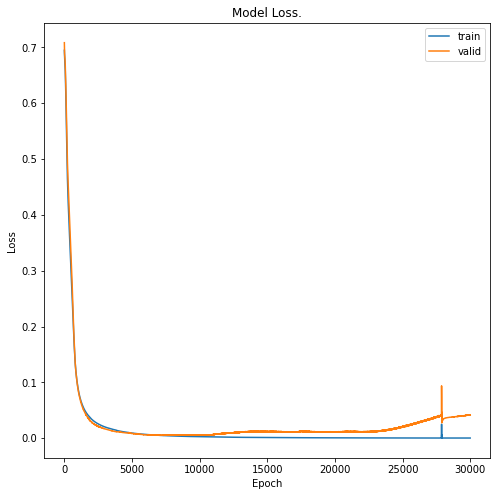

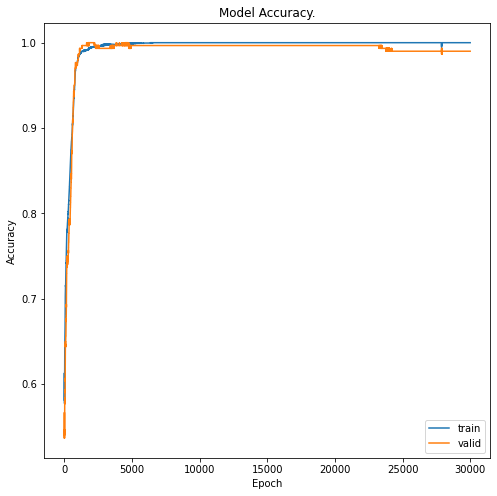

In [4]:
import torch
from util.model import FFNN
from util.loop import train

epochs = 30000
batch_size = 2400   # batch gradient descent
random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    print(f"\n\nRandom State {random_state}:")
    _, valid_acc = train(data, model, epochs, batch_size, optimizer, validate=True, plot=True, logfile=f"data0.75_q1_random_state_{random_state}")
    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 99.400001% +/- 0.002788864095442989


# Creating a dictionary of different domain data

Needs to be created for the following questions.

In [3]:
Data = {}
for domain in set(data['d_train']):
    Data[domain] = {}
    for data_set in ['train', 'valid']:
        index = data[f'd_{data_set}']==domain
        for key in data.keys():
            if data_set in key: Data[domain][key] = data[key][index]

# Question 2: Implement a multi-domain model using knowledge distillation

## Teacher Model Training



 Teacher Model Training for Domain 0


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 4.095449185115285e-05
INFO:util.loop:Validation loss: 0.04528545215725899
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


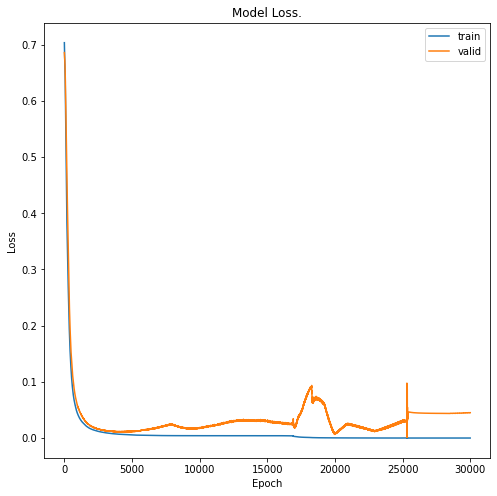

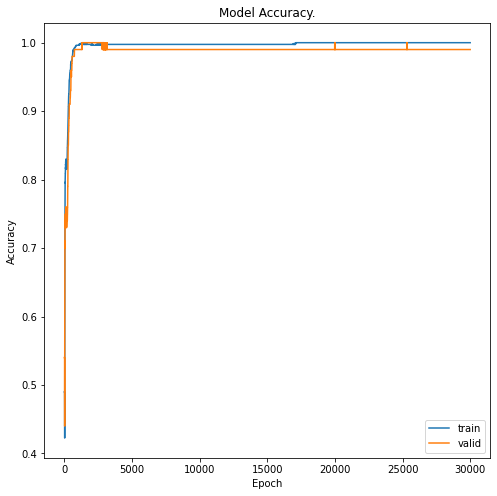



 Teacher Model Training for Domain 1


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.344645863189726e-09
INFO:util.loop:Validation loss: 2.264973986143559e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%


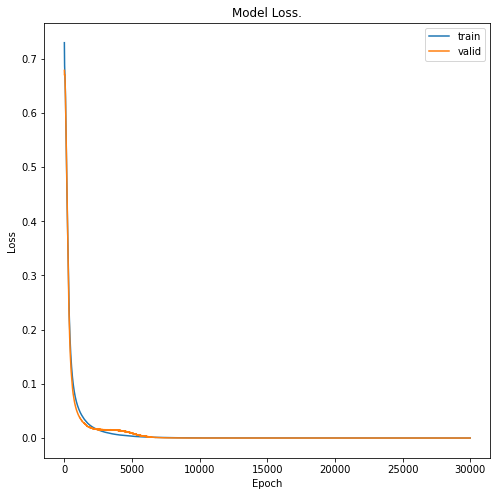

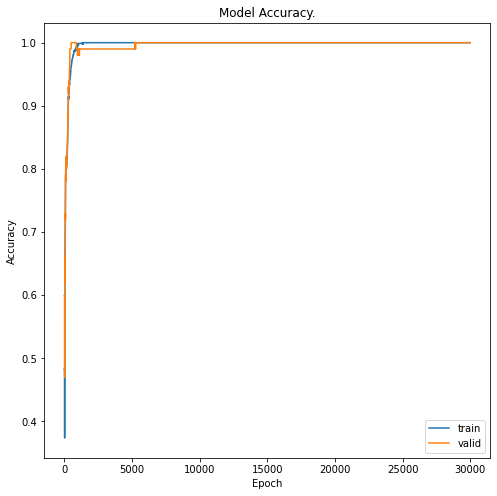



 Teacher Model Training for Domain 2


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014381363871507347
INFO:util.loop:Validation loss: 0.022229384630918503
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%


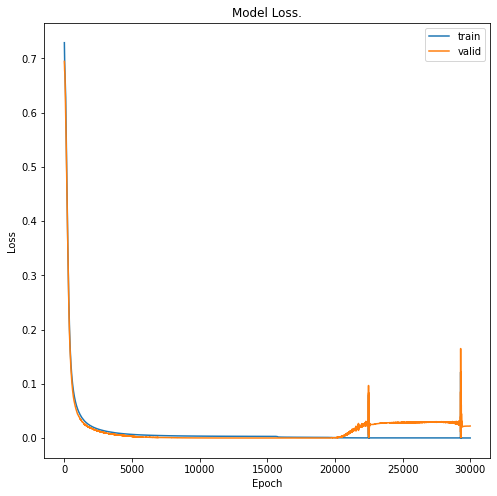

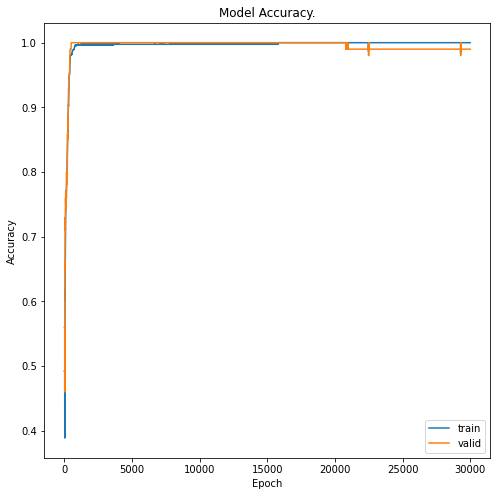

In [7]:
import torch
from util.model import FFNN
from util.loop import train

Teacher_Model = {}
for domain in set(data['d_train']):
    epochs = 30000
    batch_size = len(Data[domain]['x_train'])   # batch gradient descent
    Teacher_Model[domain] = FFNN(random_state=0)
    optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
    print(f"\n\n Teacher Model Training for Domain {domain}")
    Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, plot=True)

## Storing logits offline infered from trained teacher models

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for domain in set(data['d_train']):
    with torch.no_grad(): 
        Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
        Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

## Student Training

INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.09178471565246582
INFO:util.loop:Validation loss: 0.32043156027793884
INFO:util.loop:Train acc: 99.62500%
INFO:util.loop:Validation acc: 99.33333%


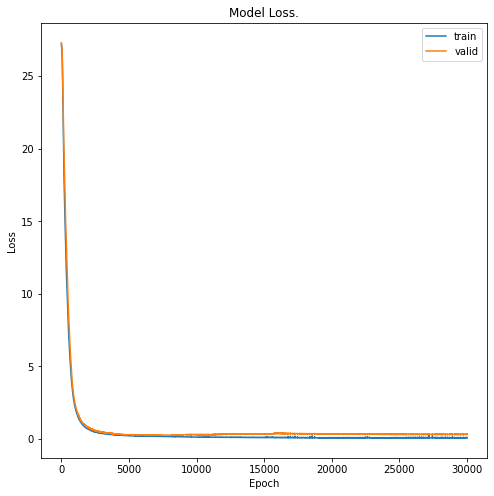

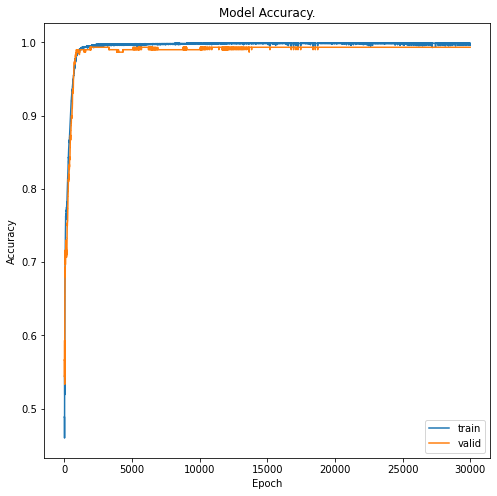

In [10]:
import torch
from util.model import FFNN
from util.loop import student_train

epochs = 30000
batch_size_ratio = 1.0   # batch gradient descent
alpha = 0.5
T = 9.0
Student_Model = FFNN(random_state=0)
optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
Student_Model, _ = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, plot=True)

## Complete run using 5 random states



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 4.095449185115285e-05
INFO:util.loop:Validation loss: 0.04528545215725899
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.344645863189726e-09
INFO:util.loop:Validation loss: 2.264973986143559e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00014381363871507347
INFO:util.loop:Validation loss: 0.022229384630918503
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Student Model Training [Random State 0]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.09178471565246582
INFO:util.loop:Validation loss: 0.32043156027793884
INFO:util.loop:Train acc: 99.62500%
INFO:util.loop:Validation acc: 99.33333%


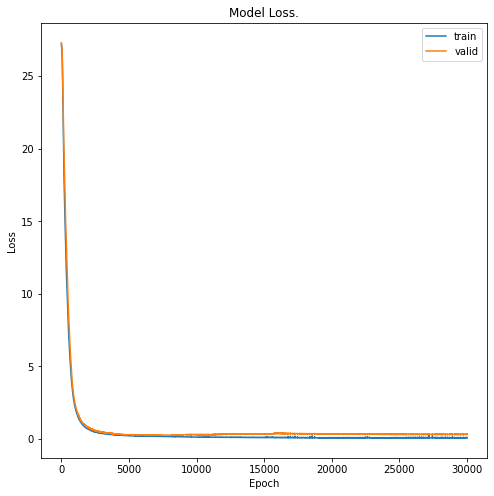

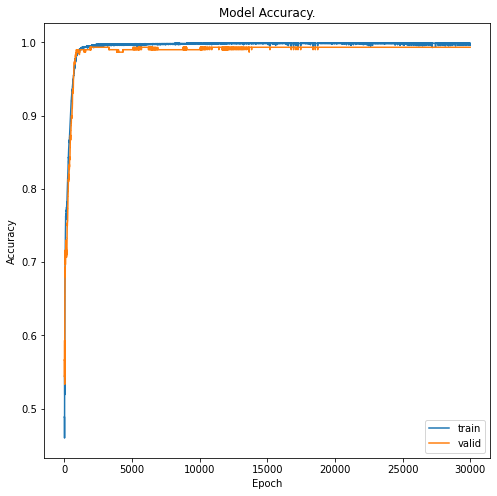



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.00011128041660413146
INFO:util.loop:Validation loss: 1.211097924169735e-06
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 1.1266030014667194e-05
INFO:util.loop:Validation loss: 0.24841706454753876
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 4.380260179459583e-06
INFO:util.loop:Validation loss: 3.576278384542775e-09
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.08558741956949234
INFO:util.loop:Validation loss: 0.16123557090759277
INFO:util.loop:Train acc: 99.95833%
INFO:util.loop:Validation acc: 99.66667%


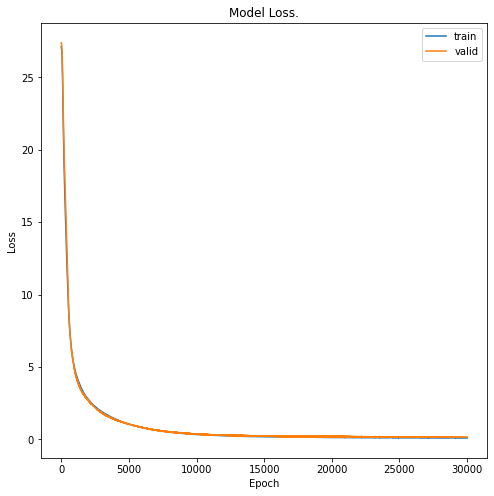

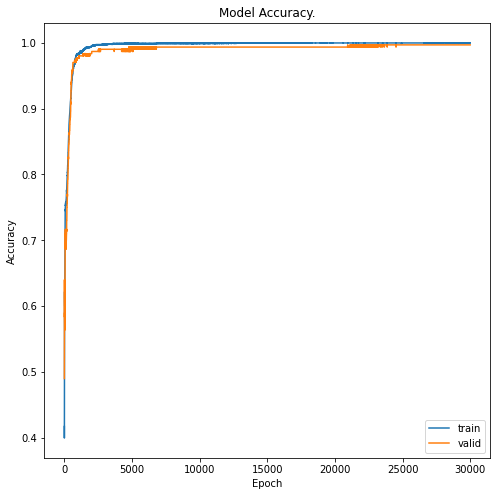



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 4.684655868913978e-05
INFO:util.loop:Validation loss: 0.06552089005708694
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.565558017726289e-06
INFO:util.loop:Validation loss: 0.06679210811853409
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 5.884230063202267e-07
INFO:util.loop:Validation loss: 0.0001107144053094089
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.08054434508085251
INFO:util.loop:Validation loss: 0.24582605063915253
INFO:util.loop:Train acc: 99.95833%
INFO:util.loop:Validation acc: 100.00000%


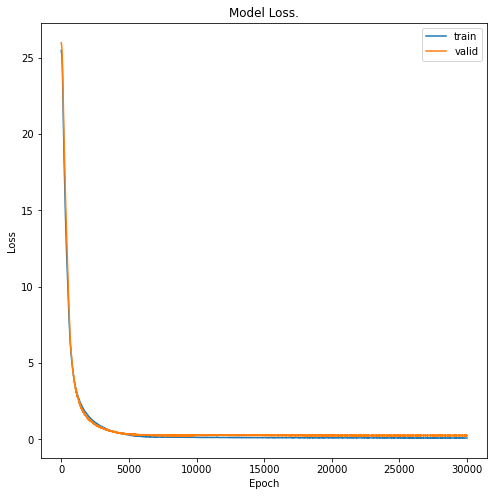

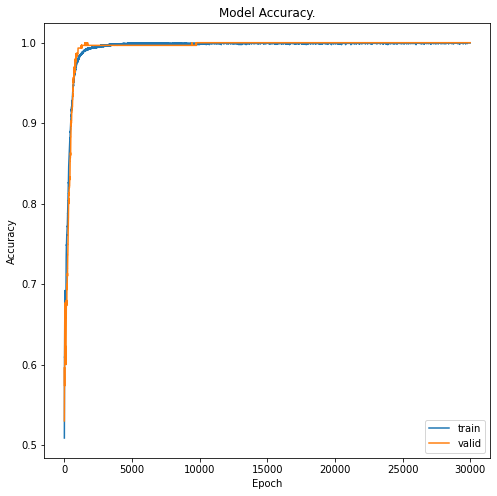



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 4.509646896622144e-05
INFO:util.loop:Validation loss: 0.09129679203033447
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 8.791678496322675e-09
INFO:util.loop:Validation loss: 8.55886582940002e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 7.95836967881769e-06
INFO:util.loop:Validation loss: 2.6225700366921956e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.0747443363070488
INFO:util.loop:Validation loss: 0.15172837674617767
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.66667%


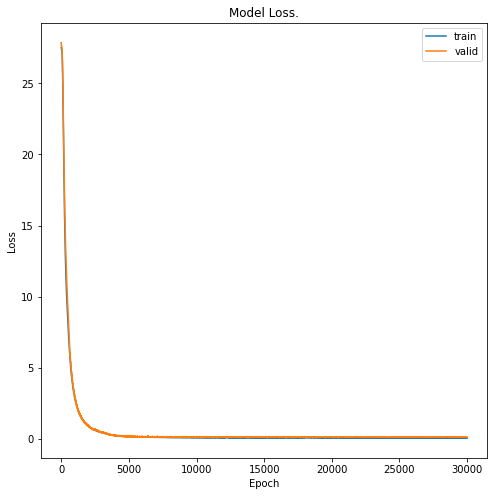

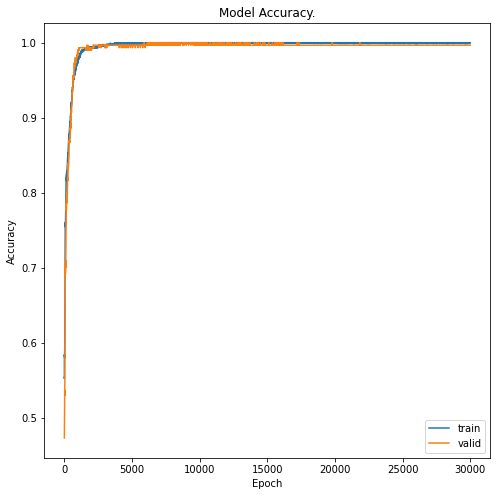



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.972448394051753e-05
INFO:util.loop:Validation loss: 0.13165892660617828
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 3.7252891882388894e-09
INFO:util.loop:Validation loss: 3.804079824476503e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 6.36129334452562e-05
INFO:util.loop:Validation loss: 5.221230594543158e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Epoch 30000
INFO:util.loop:Train loss: 0.07408931106328964
INFO:util.loop:Validation loss: 0.2296743392944336
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 99.33333%


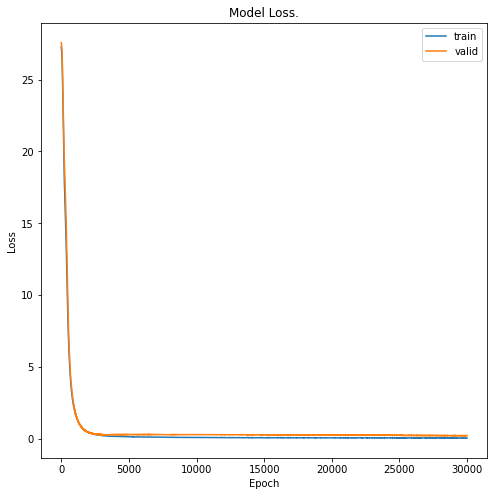

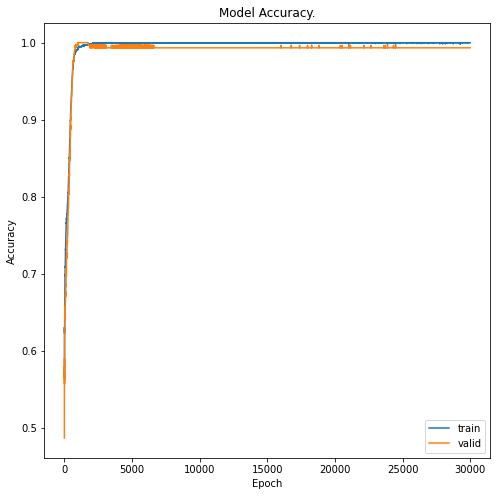

In [11]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:

    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, 
                                         plot=False, logfile=f"data0.75_q2_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.5
    T = 9.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, 
                                             plot=True, logfile=f"data0.75_q2_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)

In [12]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 99.600000% +/- 0.002788864095442989


# Question 3: Ways to improve

## Method 1: Tuning and Checkpointing best model.

Tuning alpha value to shift weightage between soft label training and hard label training. Early stopping at least validation loss checkpoint for the teacher and student also helps improving the final results.



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 25330 based on val_loss
INFO:util.loop:Train loss: 0.00457810889929533
INFO:util.loop:Validation loss: 0.0010977383935824037
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 29904 based on val_loss
INFO:util.loop:Train loss: 8.642668802849585e-09
INFO:util.loop:Validation loss: 1.788137637959153e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 19622 based on val_loss
INFO:util.loop:Train loss: 0.001062814611941576
INFO:util.loop:Validation loss: 2.495082480891142e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Checkpoint Epoch 29340 based on val_loss
INFO:util.loop:Train loss: 0.08771583437919617
INFO:util.loop:Validation loss: 0.16855692863464355
INFO:util.loop:Train acc: 99.83333%
INFO:util.loop:Validation acc: 99.66667%


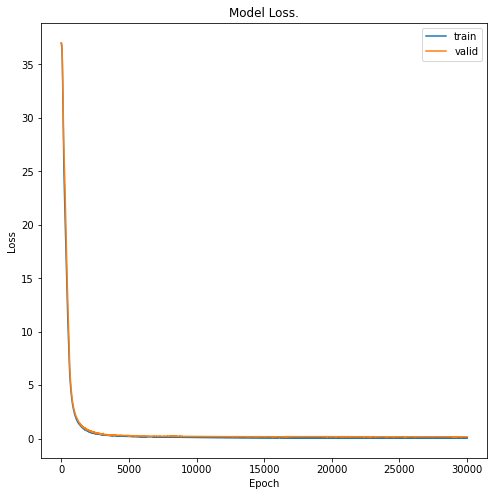

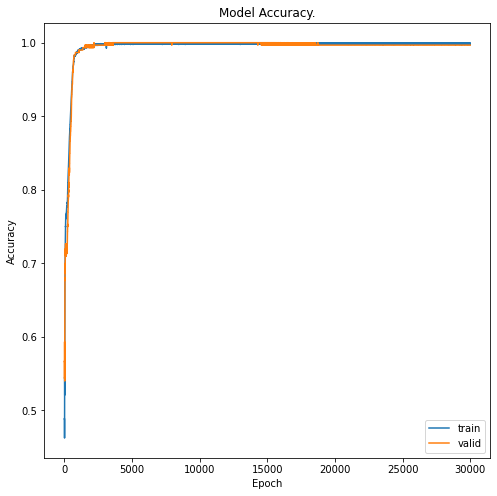



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 24452 based on val_loss
INFO:util.loop:Train loss: 0.0010160322999581695
INFO:util.loop:Validation loss: 2.276883606100455e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 2198 based on val_loss
INFO:util.loop:Train loss: 0.016944987699389458
INFO:util.loop:Validation loss: 0.0221109576523304
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 16790 based on val_loss
INFO:util.loop:Train loss: 0.034501004964113235
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 99.25000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Checkpoint Epoch 29993 based on val_loss
INFO:util.loop:Train loss: 0.12295392900705338
INFO:util.loop:Validation loss: 0.186643585562706
INFO:util.loop:Train acc: 99.37499%
INFO:util.loop:Validation acc: 99.66667%


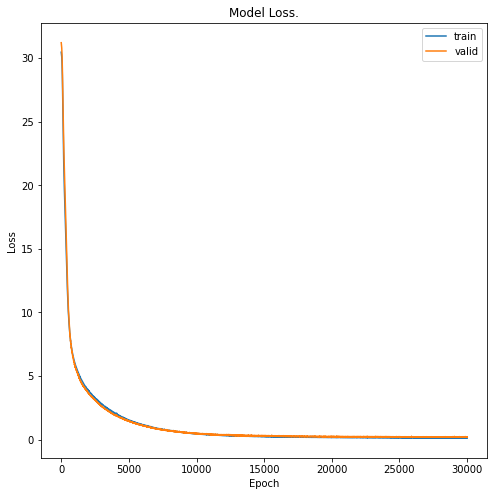

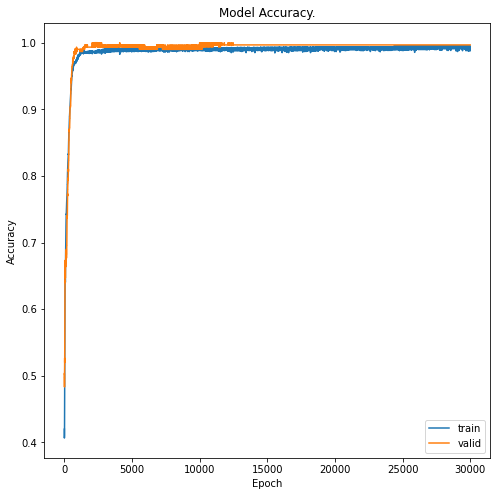



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 24032 based on val_loss
INFO:util.loop:Train loss: 0.0025906136725097895
INFO:util.loop:Validation loss: 6.667507932434091e-06
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 19469 based on val_loss
INFO:util.loop:Train loss: 0.08384586870670319
INFO:util.loop:Validation loss: 0.00010055666643893346
INFO:util.loop:Train acc: 98.37500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 20705 based on val_loss
INFO:util.loop:Train loss: 3.243768878746778e-05
INFO:util.loop:Validation loss: 1.9907926684936683e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 29953 based on val_loss
INFO:util.loop:Train loss: 0.11223820596933365
INFO:util.loop:Validation loss: 0.18486787378787994
INFO:util.loop:Train acc: 99.20833%
INFO:util.loop:Validation acc: 99.66667%


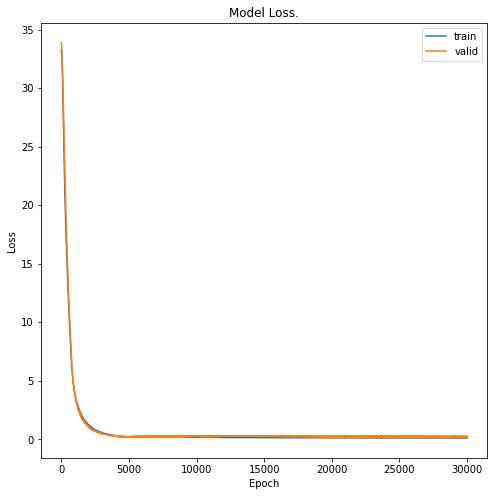

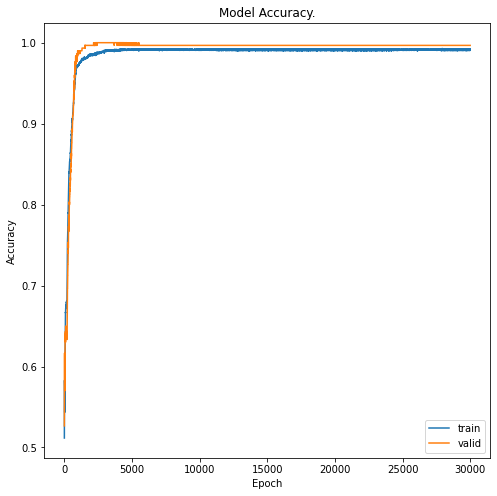



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 26443 based on val_loss
INFO:util.loop:Train loss: 0.0007231371128000319
INFO:util.loop:Validation loss: 0.0013587693683803082
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 29988 based on val_loss
INFO:util.loop:Train loss: 8.493654668484396e-09
INFO:util.loop:Validation loss: 7.867508315939631e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 20083 based on val_loss
INFO:util.loop:Train loss: 0.005402471404522657
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Checkpoint Epoch 6840 based on val_loss
INFO:util.loop:Train loss: 0.22756581008434296
INFO:util.loop:Validation loss: 0.1988314390182495
INFO:util.loop:Train acc: 99.70832%
INFO:util.loop:Validation acc: 99.33333%


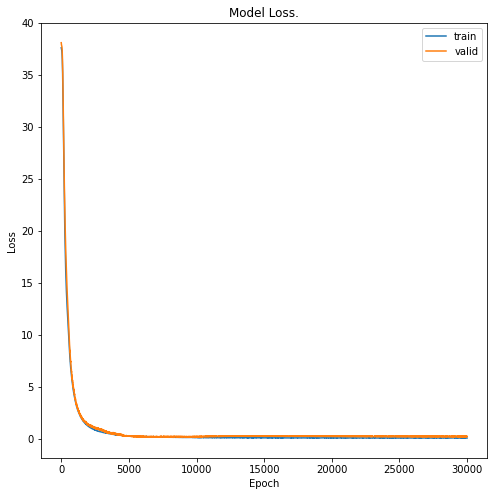

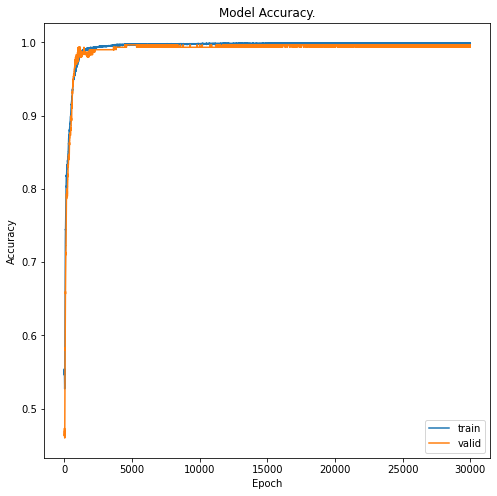



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 4014 based on val_loss
INFO:util.loop:Train loss: 0.005936174653470516
INFO:util.loop:Validation loss: 0.015340789221227169
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 29976 based on val_loss
INFO:util.loop:Train loss: 3.7252891882388894e-09
INFO:util.loop:Validation loss: 2.980106000904925e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 26423 based on val_loss
INFO:util.loop:Train loss: 0.008096592500805855
INFO:util.loop:Validation loss: 2.384185515680315e-09
INFO:util.loop:Train acc: 99.75000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 13976 based on val_loss
INFO:util.loop:Train loss: 0.12613554298877716
INFO:util.loop:Validation loss: 0.25253504514694214
INFO:util.loop:Train acc: 99.66667%
INFO:util.loop:Validation acc: 100.00000%


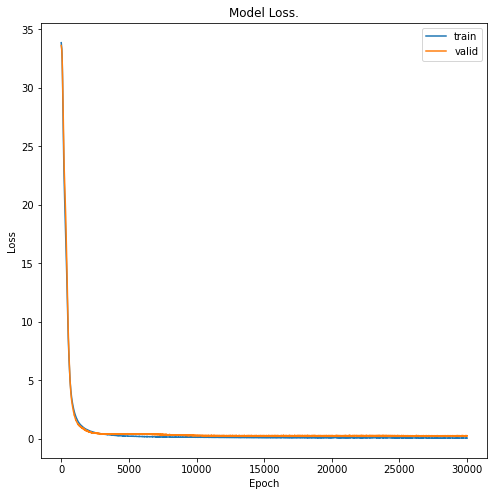

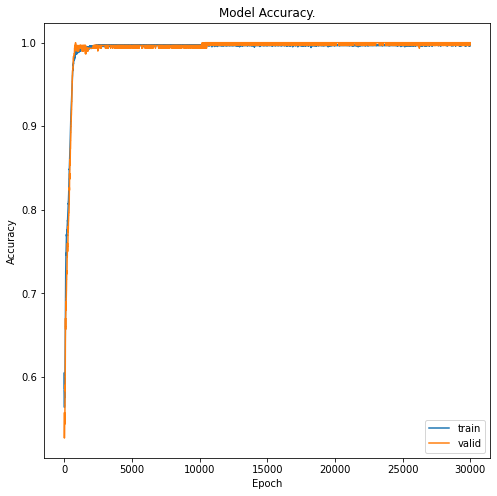

In [4]:
import torch
from util.model import FFNN
from util.loop import train, student_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, checkpoint_val_best="loss",
                                         plot=False, logfile=f"data0.75_q31_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.69
    T = 9.0
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T, checkpoint_val_best="loss",
                                             plot=True, logfile=f"data0.75_q31_student_random_state_{random_state}")

    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 99.666667% +/- 0.0023570203561232377


## Method 2: Annealing Knowledge Distillation

Annealing temperature value would allow the student to learn from flatter convex curvatures (non-convex here considered as a combination of convex landscapes), there by starting from a reduced differences in the multiple domain functions, i.e., adapting from the common feature learning.

The solution is adapted from the following reference. Instead of training with annealing T=1 steps and then fine-tuning with CE, alpha weighting is implemented to do it simultaneously.

_Ref: Jafari, A., Rezagholizadeh, M., Sharma, P. and Ghodsi, A., 2021, April. Annealing Knowledge Distillation. 
       In Proceedings of the 16th Conference of the European Chapter of the Association for Computational Linguistics: 
       Main Volume (pp. 2493-2504)._



 Teacher Model Training for Domain 0 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 25330 based on val_loss
INFO:util.loop:Train loss: 0.00457810889929533
INFO:util.loop:Validation loss: 0.0010977383935824037
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 29904 based on val_loss
INFO:util.loop:Train loss: 8.642668802849585e-09
INFO:util.loop:Validation loss: 1.788137637959153e-08
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 0]


INFO:util.loop:
Checkpoint Epoch 19622 based on val_loss
INFO:util.loop:Train loss: 0.001062814611941576
INFO:util.loop:Validation loss: 2.495082480891142e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 0]


INFO:util.loop:
Checkpoint Epoch 25607 based on val_loss
INFO:util.loop:Train loss: 1705.6754150390625
INFO:util.loop:Validation loss: 2445.459228515625
INFO:util.loop:Train acc: 97.75000%
INFO:util.loop:Validation acc: 97.66667%


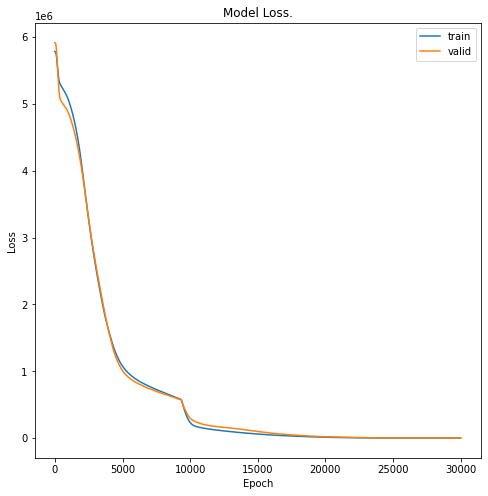

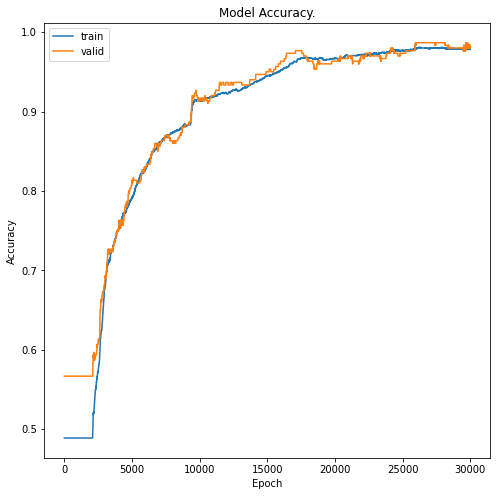



 Teacher Model Training for Domain 0 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 24452 based on val_loss
INFO:util.loop:Train loss: 0.0010160322999581695
INFO:util.loop:Validation loss: 2.276883606100455e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 2198 based on val_loss
INFO:util.loop:Train loss: 0.016944987699389458
INFO:util.loop:Validation loss: 0.0221109576523304
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 2 [Random State 10]


INFO:util.loop:
Checkpoint Epoch 16790 based on val_loss
INFO:util.loop:Train loss: 0.034501004964113235
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 99.25000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 10]


INFO:util.loop:
Checkpoint Epoch 29171 based on val_loss
INFO:util.loop:Train loss: 1008.9542846679688
INFO:util.loop:Validation loss: 4347.46044921875
INFO:util.loop:Train acc: 81.74999%
INFO:util.loop:Validation acc: 86.33333%


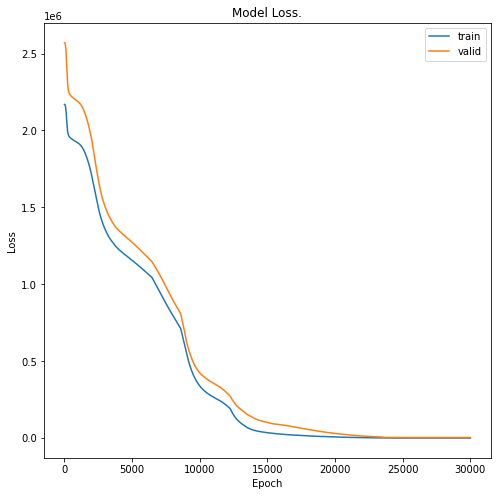

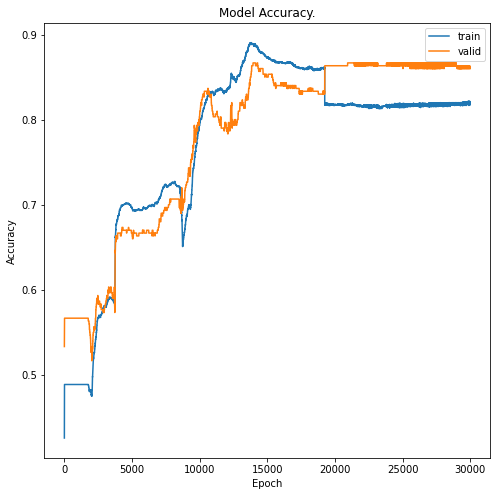



 Teacher Model Training for Domain 0 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 24032 based on val_loss
INFO:util.loop:Train loss: 0.0025906136725097895
INFO:util.loop:Validation loss: 6.667507932434091e-06
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 19469 based on val_loss
INFO:util.loop:Train loss: 0.08384586870670319
INFO:util.loop:Validation loss: 0.00010055666643893346
INFO:util.loop:Train acc: 98.37500%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 20705 based on val_loss
INFO:util.loop:Train loss: 3.243768878746778e-05
INFO:util.loop:Validation loss: 1.9907926684936683e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 1234]


INFO:util.loop:
Checkpoint Epoch 30000 based on val_loss
INFO:util.loop:Train loss: 3634.48828125
INFO:util.loop:Validation loss: 11454.9150390625
INFO:util.loop:Train acc: 92.20833%
INFO:util.loop:Validation acc: 91.33332%


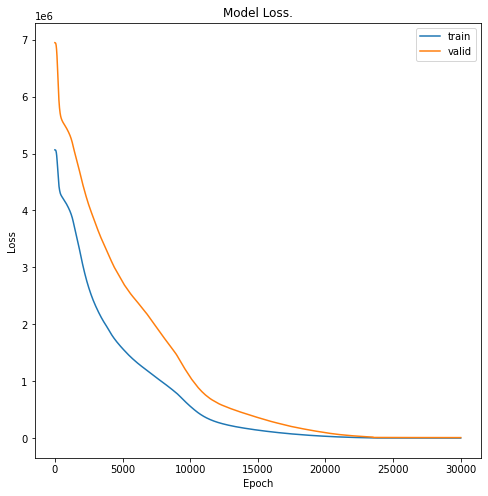

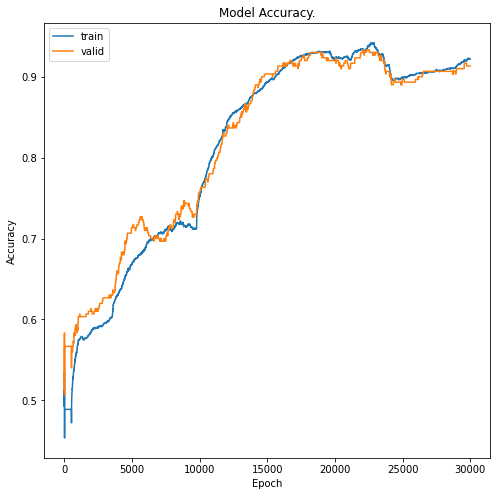



 Teacher Model Training for Domain 0 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 26443 based on val_loss
INFO:util.loop:Train loss: 0.0007231371128000319
INFO:util.loop:Validation loss: 0.0013587693683803082
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 1 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 29988 based on val_loss
INFO:util.loop:Train loss: 8.493654668484396e-09
INFO:util.loop:Validation loss: 7.867508315939631e-07
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 99]


INFO:util.loop:
Checkpoint Epoch 20083 based on val_loss
INFO:util.loop:Train loss: 0.005402471404522657
INFO:util.loop:Validation loss: 0.0
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 99]


INFO:util.loop:
Checkpoint Epoch 28871 based on val_loss
INFO:util.loop:Train loss: 2065.984130859375
INFO:util.loop:Validation loss: 5329.47216796875
INFO:util.loop:Train acc: 97.79167%
INFO:util.loop:Validation acc: 97.00000%


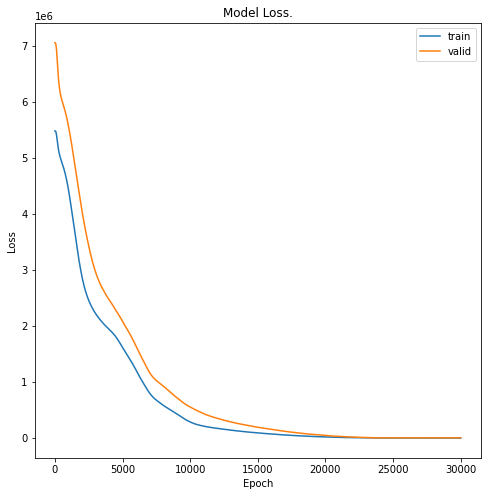

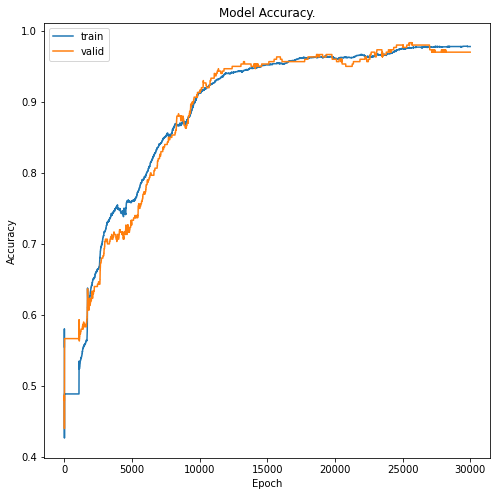



 Teacher Model Training for Domain 0 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 4014 based on val_loss
INFO:util.loop:Train loss: 0.005936174653470516
INFO:util.loop:Validation loss: 0.015340789221227169
INFO:util.loop:Train acc: 99.87500%
INFO:util.loop:Validation acc: 98.99999%




 Teacher Model Training for Domain 1 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 29976 based on val_loss
INFO:util.loop:Train loss: 3.7252891882388894e-09
INFO:util.loop:Validation loss: 2.980106000904925e-05
INFO:util.loop:Train acc: 100.00000%
INFO:util.loop:Validation acc: 100.00000%




 Teacher Model Training for Domain 2 [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 26423 based on val_loss
INFO:util.loop:Train loss: 0.008096592500805855
INFO:util.loop:Validation loss: 2.384185515680315e-09
INFO:util.loop:Train acc: 99.75000%
INFO:util.loop:Validation acc: 100.00000%




 Student Model Training [Random State 2021]


INFO:util.loop:
Checkpoint Epoch 29993 based on val_loss
INFO:util.loop:Train loss: 2936.861083984375
INFO:util.loop:Validation loss: 5968.67919921875
INFO:util.loop:Train acc: 95.45833%
INFO:util.loop:Validation acc: 96.33333%


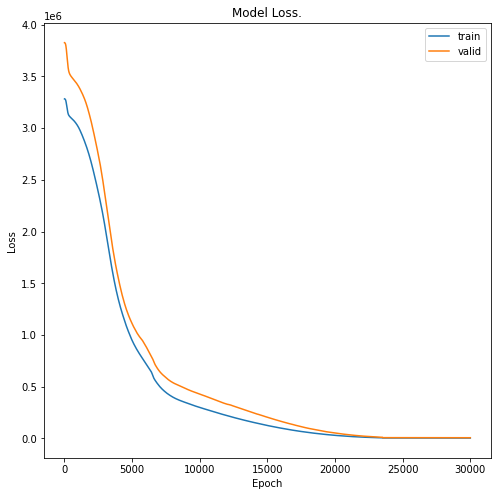

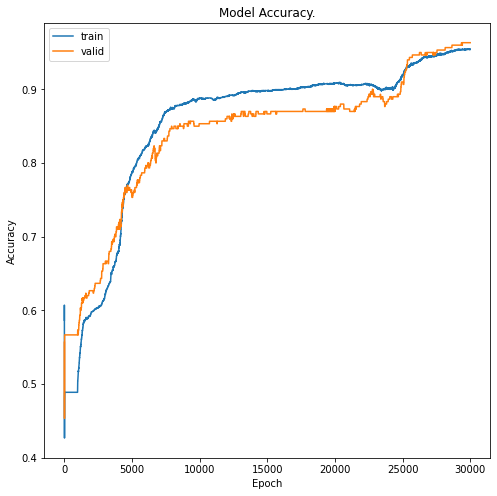

In [4]:
import torch
from util.model import FFNN
from util.loop import train, student_train_KD_annealing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_states = [0, 10, 1234, 99, 2021]
valid_accuracies = []
for random_state in random_states:
    # Teacher Training:
    Teacher_Model = {}
    for domain in set(data['d_train']):
        epochs = 30000
        batch_size = len(Data[domain]['x_train'])   # batch gradient descent
        Teacher_Model[domain] = FFNN(random_state=random_state)
        optimizer = torch.optim.Adam(Teacher_Model[domain].parameters(), 1e-3)
        print(f"\n\n Teacher Model Training for Domain {domain} [Random State {random_state}]")
        Teacher_Model[domain], _ = train(Data[domain], Teacher_Model[domain], epochs, batch_size, optimizer, checkpoint_val_best="loss",
                                         plot=False, logfile=f"data0.75_q32_teacher_domain_{domain}_random_state_{random_state}")

        # Teacher Inference and offline saving logits
        with torch.no_grad(): 
            Data[domain]['z_train'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_train'], dtype=torch.float32).to(device))
            Data[domain]['z_valid'] = Teacher_Model[domain].Z(torch.tensor(Data[domain]['x_valid'], dtype=torch.float32).to(device))

    # Student Training w/ Annealing Knowledge Distillation
    epochs = 30000
    batch_size_ratio = 1.0   # batch gradient descent
    alpha = 0.69
    T_max = 9
    Student_Model = FFNN(random_state=random_state)
    optimizer = torch.optim.Adam(Student_Model.parameters(), 1e-3)
    print(f"\n\n Student Model Training [Random State {random_state}]")
    Student_Model, valid_acc = student_train_KD_annealing(Data, Student_Model, epochs, batch_size_ratio, optimizer, alpha, T_max, checkpoint_val_best="loss",
                                                          plot=True, logfile=f"data0.75_q32_student_random_state_{random_state}_{T_max}")

    valid_accuracies.append(valid_acc)

In [5]:
import pandas as pd
stat_df = pd.DataFrame({"Random Sate": random_states, "Valid Accuracy": valid_accuracies})
mean = stat_df["Valid Accuracy"].mean()
std = stat_df["Valid Accuracy"].std()
print(f"Based on the 5 random state runs, the validation accuracy is {mean:%} +/- {std}")

Based on the 5 random state runs, the validation accuracy is 93.733330% +/- 0.04832761233827468
